## Phase 1:
-   CTPN
-   SVN

### Load file path

In [1]:
from os import walk
import np as np
import plt as plt
import PIL
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics

In [2]:
# get link of ads and non ads images
from os import walk
f_test = []
ctpn_output_test = "../data/dataset/ctpn_output/testing_data/"
for dirpath, dirnames, filenames in os.walk(ctpn_output_test):
    f_test.append(filenames)
    break
f_test = f_test[0]

In [3]:
ads_test_data = []
for name in f_test:
    ads_test_data.append([i[:-1] for i in open(ctpn_output_test + name,'r').readlines() if i !="\n"])

Get height and width of image

In [4]:
img_test_path = "../data/dataset/testing_data"
hw_test = [PIL.Image.open(img_test_path + "/" + name[:-3] + "png").size for name in f_test] 

In [5]:
def extract_info(arr):
    arr = [int(i) for i in arr.split(",")[:-1]]
    h_b = arr[-1]-arr[1]
    w_b = arr[2] - arr[0]
    h_cb = (arr[-1]+arr[1])//2
    w_cb = (arr[2]+arr[0])//2
    return h_b,w_b,h_cb,w_cb

In [6]:
def sort_weight(bb, temp_scale,temp_distance=None):
    if temp_distance != None:
        temp_scale_sort = sorted(temp_scale)
        temp_distance_sort = sorted(temp_distance)
        bb_t = set()
        for distance in temp_distance_sort[-n_att:]:
            bb_t.add(bb[temp_distance_sort.index(distance)])
        for scale in temp_scale_sort[-n_att:]:
            bb_t.add(bb[temp_scale_sort.index(scale)])
        return list(bb_t),temp_scale_sort[-n_att:] + temp_distance_sort[-n_att:]
    else:
        w = sorted(temp_scale)
        bb_t = []
        for i in range(n_att):
            bb_t.append(bb[temp_scale.index(w[-n_att+i])])
        return bb_t,w[-n_att:]

![expression](https://drive.google.com/file/d/10s70Ooov1ICpqj5myX52Z3xdoz2BnffD/view?usp=sharing)

In [7]:
n_att = 10
w_test = []
for bbs,hw in zip(ads_test_data,hw_test):
    if len(bbs) <n_att:
        continue
    temp_scale = []
    temp_distance = []
    for bb in bbs:
        h_b,w_b,h_cb,w_cb =extract_info(bb)
        weight = (3*h_b*(abs(h_cb-hw[1])+1)*(abs(w_cb-hw[0])+1))/w_b
        temp_scale.append(h_b/w_b)
        temp_distance.append((abs(h_cb-hw[1])+1)*(abs(w_cb-hw[0])+1)/(hw[0]*hw[1]))
    bb_t, w_t = sort_weight(bbs, temp_scale,temp_distance)
    w_test.append(w_t)


In [8]:
X_test = w_test
y_test = [0]*len(w_test)
for i in range(len(f_test)):
    if f_test[i][:3] == "ads":
        y_test[i] = 1

## Load SVM by joblid

In [11]:
import joblib
import sklearn.metrics as metrics

In [12]:
clf2 = joblib.load("../phase_1/svm_phase_1_v2.pkl")
clf2.probability = True
test_phase_1 = [[i[0],i[1]] for i in clf2.predict_proba(X_test)]

In [13]:
y_test[:10]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

In [14]:
test_phase_1[:10]

[[0.9330630011722724, 0.0669369988277276],
 [0.5087130876706271, 0.49128691232937305],
 [0.8106662835023474, 0.18933371649765254],
 [0.9358970039247465, 0.06410299607525352],
 [0.8943587241859536, 0.10564127581404649],
 [0.9704640733549801, 0.02953592664501997],
 [0.912386283667497, 0.08761371633250299],
 [0.9751716174878288, 0.024828382512171197],
 [0.4432750450126529, 0.5567249549873472],
 [0.476050081291567, 0.523949918708433]]

In [15]:
y_test_phase_1 = [0] * len(y_test)
for i,r in enumerate(test_phase_1):
    if r[0] > r[1]:
        y_test_phase_1[i] = 1

In [16]:
metrics.confusion_matrix(y_test,y_test_phase_1)

array([[266,  27],
       [ 23, 350]], dtype=int64)

In [17]:
metrics.accuracy_score(y_test,y_test_phase_1)

0.924924924924925

## Phase 2:
-   Xception

In [18]:
from tensorflow.keras.models import load_model
import os

In [19]:
from PIL import Image
import np as np
from skimage import transform
import shutil
import keras
import tensorflow as tf

In [20]:
def load(filename):
    np_image = Image.open(filename)
    np_image = np.array(np_image).astype('float32')
    np_image = transform.resize(np_image,(180,180,3))
    np_image = np.expand_dims(np_image, axis = 0)
    return np_image

In [21]:
model_phase_2 = load_model('../phase_2/xception/model/save_at_40.h5')

In [22]:
test_phase_2 = []
for name in f_test:
    r =model_phase_2.predict(load(img_test_path +'/'+ name[:-3] + "png"))
    test_phase_2.append([1-r[0][0], r[0][0]])

In [24]:
test_phase_2[:10]

[[0.9996516704559326, 0.00034832954],
 [0.9999997151579407, 2.8484206e-07],
 [0.9999689133983338, 3.10866e-05],
 [0.9995241463184357, 0.00047585368],
 [0.9996791481971741, 0.0003208518],
 [0.9999999972622811, 2.737719e-09],
 [0.99847012758255, 0.0015298724],
 [0.9999999709479699, 2.905203e-08],
 [0.9999993381081822, 6.618918e-07],
 [0.9999999221356433, 7.786436e-08]]

In [26]:
y_phase_2 = [0] * len(y_test)
for i,r in enumerate(test_phase_2):
    if r[0] > r[1]:
        y_phase_2[i] = 1

In [28]:
metrics.confusion_matrix(y_test,y_phase_2)

array([[245,  48],
       [  6, 367]], dtype=int64)

In [26]:
metrics.accuracy_score(y,y_phase2)

0.918918918918919

### Save results of phase_1 and phase_2

In [32]:
import pickle

In [189]:
with open("./test_phase_1.pkl", "wb") as f:
    pickle.dump([list(i) for i in test_phase_1],f)
with open("./test_phase_2.pkl", "wb") as f:
    pickle.dump(test_phase_2,f)

### Load phase_1 and phase_2

In [37]:
with open("./test_phase_1.pkl", "rb") as f:
    test_phase_1 = pickle.load(f)
with open("./test_phase_2.pkl", "rb") as f:
    test_phase_2 = pickle.load(f)

## Evaluating model

In [29]:

import seaborn as sn
import plt as plt
import pandas as pd

### 1. Mean of 2 phases

In [94]:
y_pred = [0]*len(y_test)
for i in range(len(y_test)):
    ads_r = (test_phase_1[i][0] + test_phase_2[i][0])/2
    non_ads_r = (test_phase_1[i][1] + test_phase_2[i][1])/2
    if ads_r > non_ads_r:
        y_pred[i] = 1

In [95]:
r = metrics.confusion_matrix(y_test, y_pred)
print("Confusion matrix: \n", r)

Confusion matrix: 
 [[273  20]
 [  6 367]]


In [96]:
acc = metrics.accuracy_score(y_test, y_pred)
print("Accuracy: ", acc)

Accuracy:  0.960960960960961


<AxesSubplot:>

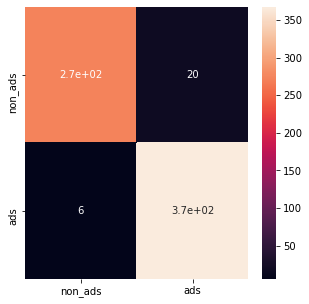

In [97]:
df_cm = pd.DataFrame(r, index = ['non_ads','ads'],
                  columns = ['non_ads','ads'])
plt.figure(figsize = (5,5))
sn.heatmap(df_cm, annot=True)

### 2. Using Neural Network to combines 2 phases

#### Train phase 1 using SVM

In [42]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import sklearn.metrics as metrics

In [43]:
f = []
ctpn_output_train = "../data/dataset/ctpn_output/training_data/"
for dirpath, dirnames, filenames in os.walk(ctpn_output_train):
    f.append(filenames)
    break
f = f[0]
ads_train_data = []
for name in f:
    ads_train_data.append([i[:-1] for i in open(ctpn_output_train + name,'r').readlines() if i !="\n"])

In [44]:
img_train_path = "../data/dataset/training_data/"
hw_train = [PIL.Image.open(img_train_path + "/" + name[:-3] + "png").size for name in f] 
n_att = 10
w_train = []
for bbs,hw in zip(ads_train_data,hw_train):
    if len(bbs) <n_att:
        continue
    temp_scale = []
    temp_distance = []
    for bb in bbs:
        h_b,w_b,h_cb,w_cb =extract_info(bb)
        weight = (3*h_b*(abs(h_cb-hw[1])+1)*(abs(w_cb-hw[0])+1))/w_b
        temp_scale.append(h_b/w_b)
        temp_distance.append((abs(h_cb-hw[1])+1)*(abs(w_cb-hw[0])+1)/(hw[0]*hw[1]))
    bb_t, w_t = sort_weight(bbs, temp_scale,temp_distance)
    w_train.append(w_t)


In [45]:
X_train = w_train
y_train = [0]*len(w_train)
for i in range(len(f)):
    if f[i][:3] == "ads":
        y_train[i] = 1

In [136]:
clf = SVC(C=1.0, kernel='rbf', probability=True).fit(X_train,y_train)
clf.probability = True

In [138]:
train_phase_1 =[[i[1],i[0]] for i in clf.predict_proba(X_train)]

In [139]:
train_phase_1[:10]

[[0.8577902247675546, 0.14220977523244543],
 [0.5159307816620388, 0.4840692183379611],
 [0.9707637909423362, 0.029236209057663866],
 [0.5461971573988542, 0.4538028426011457],
 [0.8241549489221777, 0.17584505107782228],
 [0.7972513108655531, 0.20274868913444702],
 [0.9814176349186965, 0.018582365081303478],
 [0.9470908856876485, 0.052909114312351305],
 [0.8310325692305038, 0.16896743076949622],
 [0.9310521825485829, 0.06894781745141688]]

#### Train phase 2 use Xception

In [85]:
from tensorflow.keras.models import load_model
import os
from PIL import Image
import np as np
from skimage import transform
import shutil
import keras
import tensorflow as tf

In [153]:
train_phase_2 = []
for name in f:
    r =model_phase_2.predict(load(img_train_path + name[:-3] + "png"))
    train_phase_2.append([1-r[0][0], r[0][0]])

#### Save 2 file train_phase_1 and train_phase_2

In [188]:
# Save list result of phase 1 and 2
with open("./train_phase_1.pkl", "wb") as file_io:
    pickle.dump(train_phase_1,file_io)
with open("./train_phase_2.pkl", "wb") as file_io:
    pickle.dump(train_phase_2,file_io)

#### Load 2 file train_phase_1 and train_phase_2

In [34]:
# Save list result of phase 1 and 2
with open("./train_phase_1.pkl", "rb") as file_io:
    train_phase_1 = pickle.load(file_io)
with open("./train_phase_2.pkl", "rb") as file_io:
    train_phase_2 = pickle.load(file_io)

In [35]:
from keras.models import Sequential
from keras.layers import Dense

### Train Neural Network

In [46]:
X = [train_phase_1[i] + train_phase_2[i] for i in range(len(train_phase_1))]
y = y_train

In [48]:

# define the keras model
model =Sequential()
model.add(Dense(16, input_dim=4, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [49]:
# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [50]:
model.fit(X,y,epochs=100,batch_size=10)

Epoch 1/100
156/156 [==============================] - 1s 1ms/step - loss: 0.5119 - accuracy: 0.8898
Epoch 2/100
156/156 [==============================] - 0s 1ms/step - loss: 0.0918 - accuracy: 0.9723
Epoch 3/100
156/156 [==============================] - 0s 1ms/step - loss: 0.0666 - accuracy: 0.9729
Epoch 4/100
156/156 [==============================] - 0s 1ms/step - loss: 0.0619 - accuracy: 0.9768
Epoch 5/100
156/156 [==============================] - 0s 1ms/step - loss: 0.0604 - accuracy: 0.9762
Epoch 6/100
156/156 [==============================] - 0s 1ms/step - loss: 0.0570 - accuracy: 0.9762
Epoch 7/100
156/156 [==============================] - 0s 1ms/step - loss: 0.0555 - accuracy: 0.9749
Epoch 8/100
156/156 [==============================] - 0s 1ms/step - loss: 0.0556 - accuracy: 0.9774
Epoch 9/100
156/156 [==============================] - 0s 974us/step - loss: 0.0541 - accuracy: 0.9755
Epoch 10/100
156/156 [==============================] - 0s 1ms/step - loss: 0.0549 - accu

### Evaluating NN for 2 phases

In [51]:
y_pred = model.predict([test_phase_1[i] + test_phase_2[i] for i in range(len(test_phase_1))])

In [52]:
y_pred = [1 if i >= 0.5 else 0 for i in y_pred]

In [53]:
metrics.confusion_matrix(y_test,y_pred)

array([[286,   7],
       [ 11, 362]], dtype=int64)

In [54]:
metrics.accuracy_score(y_test,y_pred)

0.972972972972973

### Using Genetic Algorithm with ANN

In [56]:
import ANN
import ga

In [62]:
X = np.array(X)
y = np.array(y)

In [63]:
X.shape

(1552, 4)

In [70]:
sol_per_pop = 8
num_parents_mating = 4
num_generations = 1000
mutation_percent = 10

C:\Users\Admin\AppData\Local\Temp/ipykernel_7588/2478646970.py:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  initial_pop_weights.append(np.array([input_HL1_weights,
C:\Users\Admin\anaconda3\lib\site-packages\numpy\core\_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


Fitness
[56.05670103 56.05670103 56.05670103 43.94329897 56.05670103 43.94329897
 56.05670103 43.94329897]
Fitness
[97.80927835 97.55154639 97.22938144 96.58505155 94.9742268  97.4871134
 43.94329897 43.94329897]
Fitness
[98.45360825 98.06701031 97.87371134 97.87371134 43.94329897 94.71649485
 43.94329897 94.20103093]
Fitness
[98.45360825 98.06701031 97.87371134 97.87371134 43.94329897 95.42525773
 97.55154639 43.94329897]
Fitness
[98.45360825 98.1314433  98.06701031 98.06701031 43.94329897 96.39175258
 96.45618557 95.68298969]
Fitness
[98.45360825 98.1314433  98.1314433  98.06701031 14.94845361 91.55927835
 91.62371134 43.94329897]
Fitness
[98.45360825 98.1314433  98.1314433  98.06701031 43.94329897 95.48969072
 95.48969072 88.98195876]
Fitness
[98.45360825 98.1314433  98.1314433  98.06701031 56.05670103 89.75515464
 77.57731959 93.68556701]
Fitness
[98.45360825 98.38917526 98.1314433  98.1314433  43.94329897 91.49484536
 86.14690722 43.94329897]
Fitness
[98.45360825 98.38917526 98.13

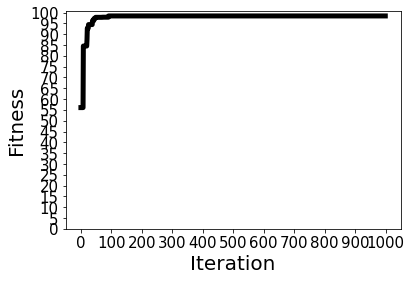

In [71]:

#Creating the initial population.
initial_pop_weights = []
for curr_sol in np.arange(0, sol_per_pop):
    HL1_neurons = 150
    input_HL1_weights = np.random.uniform(low=-0.1, high=0.1, 
                                             size=(X.shape[1], HL1_neurons))
    HL2_neurons = 60
    HL1_HL2_weights = np.random.uniform(low=-0.1, high=0.1, 
                                             size=(HL1_neurons, HL2_neurons))
    output_neurons = 2
    HL2_output_weights = np.random.uniform(low=-0.1, high=0.1, 
                                              size=(HL2_neurons, output_neurons))

    initial_pop_weights.append(np.array([input_HL1_weights, 
                                                HL1_HL2_weights, 
                                                HL2_output_weights]))

pop_weights_mat = np.array(initial_pop_weights)
pop_weights_vector = ga.mat_to_vector(pop_weights_mat)

best_outputs = []
accuracies = np.empty(shape=(num_generations))

for generation in range(num_generations):
    # print("Generation : ", generation)

    # converting the solutions from being vectors to matrices.
    pop_weights_mat = ga.vector_to_mat(pop_weights_vector, 
                                       pop_weights_mat)

    # Measuring the fitness of each chromosome in the population.
    fitness = ANN.fitness(pop_weights_mat, 
                          X, 
                          y, 
                          activation="sigmoid")
    accuracies[generation] = fitness[0]
    if generation % 50 == 0:
        print("{} Fitness".format(generation))
        print(fitness)

    # Selecting the best parents in the population for mating.
    parents = ga.select_mating_pool(pop_weights_vector, 
                                    fitness.copy(), 
                                    num_parents_mating)
    # print("Parents")
    # print(parents)

    # Generating next generation using crossover.
    offspring_crossover = ga.crossover(parents,
                                       offspring_size=(pop_weights_vector.shape[0]-parents.shape[0], pop_weights_vector.shape[1]))
    # print("Crossover")
    # print(offspring_crossover)

    # Adding some variations to the offsrping using mutation.
    offspring_mutation = ga.mutation(offspring_crossover, 
                                     mutation_percent=mutation_percent)
    # print("Mutation")
    # print(offspring_mutation)

    # Creating the new population based on the parents and offspring.
    pop_weights_vector[0:parents.shape[0], :] = parents
    pop_weights_vector[parents.shape[0]:, :] = offspring_mutation

pop_weights_mat = ga.vector_to_mat(pop_weights_vector, pop_weights_mat)
best_weights = pop_weights_mat [0, :]
acc, predictions = ANN.predict_outputs(best_weights, X, y, activation="sigmoid")
print("Accuracy of the best solution is : ", acc)

plt.plot(accuracies, linewidth=5, color="black")
plt.xlabel("Iteration", fontsize=20)
plt.ylabel("Fitness", fontsize=20)
plt.xticks(np.arange(0, num_generations+1, 100), fontsize=15)
plt.yticks(np.arange(0, 101, 5), fontsize=15)
plt.show()

f = open("weights_"+str(num_generations)+"_iterations_"+str(mutation_percent)+"%_mutation.pkl", "wb")
pickle.dump(pop_weights_mat, f)
f.close()


### Evaluating Generic algorithm with ANN

In [86]:
X_ga_test = np.array([test_phase_1[i] + test_phase_2[i] for i in range(len(test_phase_1))])
y_ga_test = np.array(y_test)

In [87]:
acc, predictions = ANN.predict_outputs(best_weights, X_ga_test, y_ga_test, activation="sigmoid")

In [90]:
metrics.confusion_matrix(y_ga_test,predictions)

array([[282,  11],
       [ 13, 360]], dtype=int64)

In [91]:
acc

96.3963963963964